# Random Forests

## What we will accomplish

In this notebook we will:
- Introduce the idea of ensemble methods
- Describe the random forest model,
- Mention how we introduce random perturbations to a decision tree,
- Extend the random forest idea to an extra trees model and
- Demonstrate how random forest models can be used for feature importance.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

# What is Ensemble Learning?

<i>Ensemble learning</i> is not a new type of supervised learning problem, but rather a different approach to solving supervised learning problems.

To this point we have introduced unique algorithms for solving a particular problem with the thought that we would try some handful of these methods and choose the one single method that works best. The idea behind ensemble learning is to use all of the models in the handful (or ensemble) simultaneously to make a model that performs better than any individual. Sometimes this will involve vastly different models (for example combining $k$ nearest neighbors, logistic regression, support vector machines and decision trees) or many slight random perturbations of the same base model (hundreds of decision trees, known as a random forest). Ensemble learning can be applied for regression and classification problems alike.

## Wisdom of the crowd

Ensemble learning can be thought of as a machine learning implementation of the concept of the <i>wisdom of the crowd</i>. 

Suppose you want to know the answer to some question. Instead of basing the answer on a single person's response, you survey thousands or millions of people. To get your answer you aggregate all of the individual answers you have collected. In many cases this aggregated answer will be more correct than a single expert's answer. A fun illustration of this idea involves weighing cows, <a href="https://www.npr.org/transcripts/430372183">https://www.npr.org/transcripts/430372183</a>.

## Forests are an ensemble of trees

The <i>random forest</i> model is made by building many different decision trees. These trees are made "different" through a variety of random perturbations (more on this later in the notebook). Random forests are thus an ensemble of decision tree models.

We will demonstrate the advantages of this ensemble with the synthetic data set we used in our decision tree classification notebook.

### Extra-trees

An variant of random forests is know as extra-trees. This algorithm is just like a random forest, but in addition to randomly selecting a handful of features to optimize it also randomly selects the cutpoints instead of having the tree search for the optimal one.

This algorithm is faster than random forests, but does tend to have a little more bias. Typically you will have to build both classifiers and compare measures via cross-validation to decide if an extra-trees classifier is better than a standard random forest.

This algorithm can be enacted using `ExtraTreesClassifier` from `sklearn`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html</a>.

In [2]:
np.random.seed(216)

n_samples = 1000
X = np.random.uniform(low = -2, high = 2, size=(n_samples,2))

y = np.zeros(n_samples)
y[((X[:,0]-1)**2 +X[:,1]**2 > 1) & (X[:,0]**2 + X[:,1]**2 < 4)] = 1
y[((X[:,0]-1)**2 +X[:,1]**2 < 1)] = 2

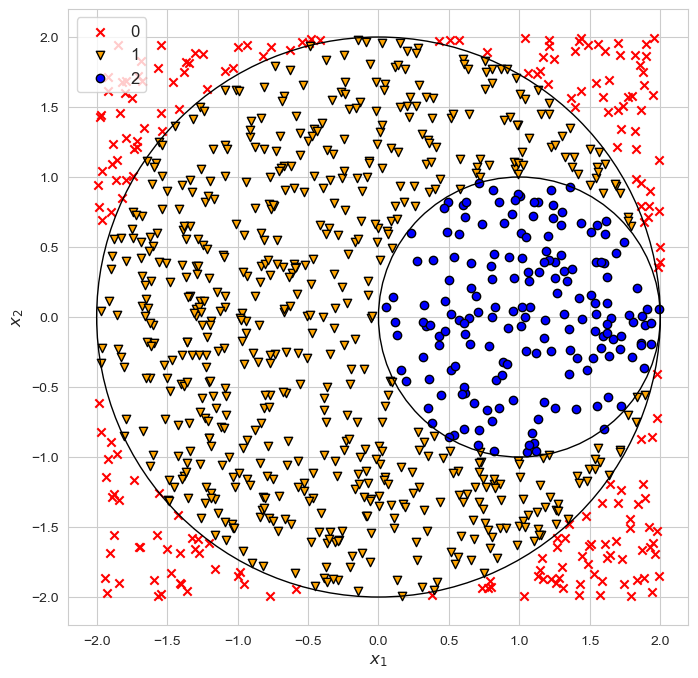

In [3]:
plt.figure(figsize = (8,8))

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue', label = "2")
plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))

plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)
plt.legend(fontsize=12, loc=2)

plt.show()

Let's compare the decision boundaries produced on these data with a decision tree, a random forest, and an extra trees classifier. 

In `sklearn` we can make a random forest classifier with `RandomForestClassifier`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html</a>.

We make an extra trees classifier with `ExtraTreesClassifier`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html</a>.

In [4]:
## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from tree_helpers import SkNode, traversable_nodes

In [5]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    random_state= 216)

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    #max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, # default is round(sqrt(num_features)), which in this case is 1.
    bootstrap= True, # sampling with replacement
    max_samples = 500, # number of training samples selected with replacement to build tree
    random_state = 216 # for consistency
    )

# Note:  by default all of the randomness is coming from using a random subset of features, not samples.  
# Since we have only 2 features the default settings are "worthless" for us: all 1000 trees would be identical, 
# and would only use one feature!

et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    random_state = 216 
    )


In [6]:
## Fit the models
tree.fit(X, y)

## rf and et may take slightly longer because we are fitting many trees
rf.fit(X, y)
et.fit(X,y)

ExtraTreesClassifier(max_features=2, min_samples_leaf=5, n_estimators=500,
                     random_state=216)

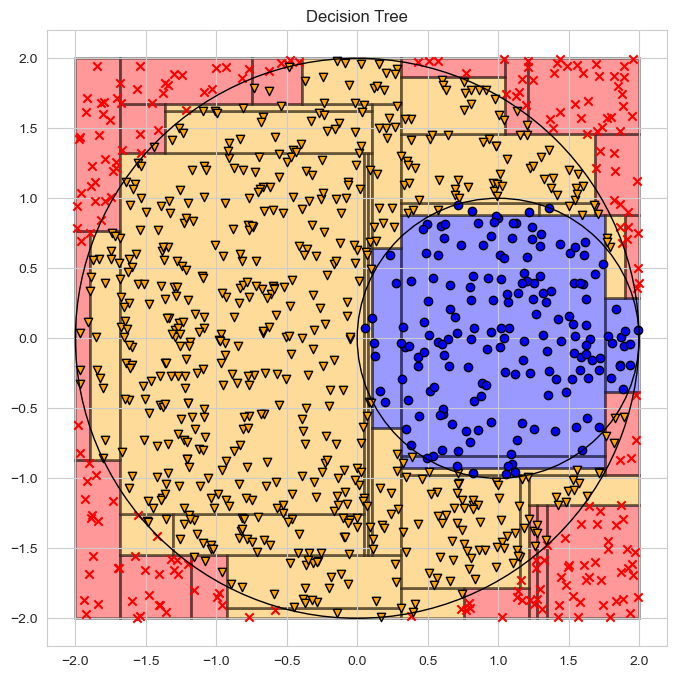

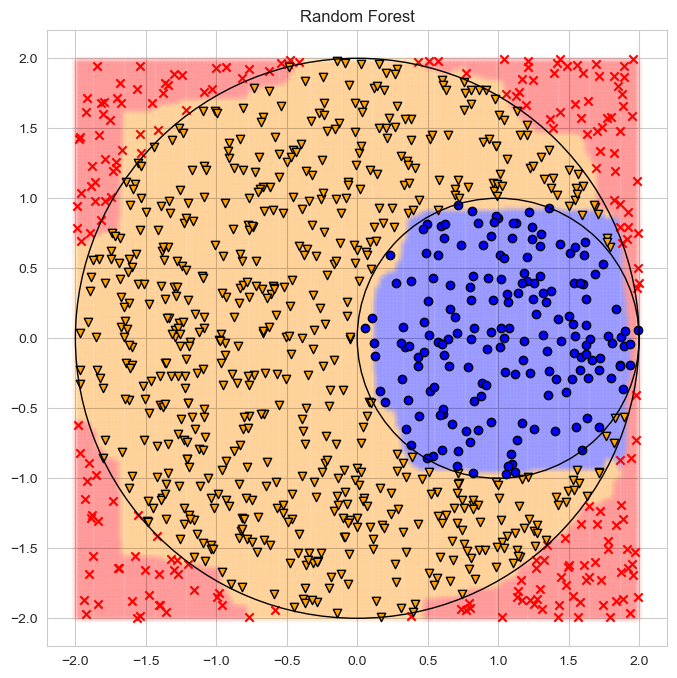

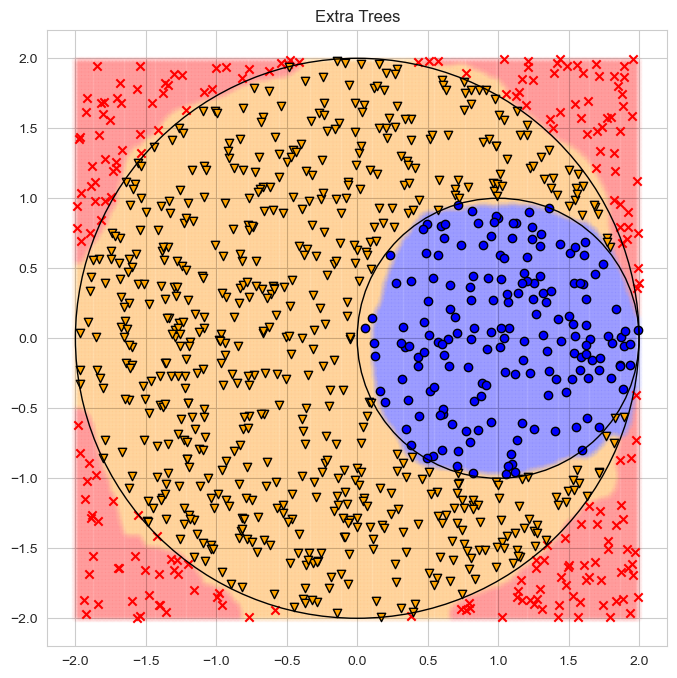

In [7]:
import matplotlib.patches as patches

## Making a grid for the decision boundaries
xx1, xx2 = np.meshgrid(np.arange(-2, 2, .01),
                          np.arange(-2, 2, .01))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

rf_preds = rf.predict(X_pred)
et_preds = et.predict(X_pred)

plt.figure(figsize=(8,8))
nodes = traversable_nodes(tree)

for node in nodes.values():
    if node.leaf:
        (xmin,ymin),(xmax,ymax) = node.find_constraints()
        xmin = np.max([xmin,-2])
        xmax = np.min([xmax,2])
        ymin = np.max([ymin,-2])
        ymax = np.min([ymax,2])
        if node.pred == 0:
            plt.gca().add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='k', facecolor = 'red', zorder = -2, alpha = 0.4))
        if node.pred == 1:
            plt.gca().add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='k', facecolor = 'orange', zorder = -2, alpha = 0.4))
        if node.pred == 2:
            plt.gca().add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='k', facecolor = 'blue', zorder = -2, alpha = 0.4))

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue', label = "2")
plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))
plt.title("Decision Tree")

plt.show()

s = 25
plt.figure(figsize=(8,8))
plt.scatter(X_pred[rf_preds==0,0],
            X_pred[rf_preds==0,1],
            alpha=.01,
            c='red',
            s=s)
plt.scatter(X_pred[rf_preds==1,0],
            X_pred[rf_preds==1,1],
            alpha=.01,
            c='orange',
            s=s)
plt.scatter(X_pred[rf_preds==2,0],
            X_pred[rf_preds==2,1],
            alpha=.01,
            c='blue',
            s=s)

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue', label = "2")
plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))
plt.title("Random Forest")

plt.show()

s = 25
plt.figure(figsize=(8,8))
plt.scatter(X_pred[et_preds==0,0],
            X_pred[et_preds==0,1],
            alpha=.01,
            c='red',
            s=s)
plt.scatter(X_pred[et_preds==1,0],
            X_pred[et_preds==1,1],
            alpha=.01,
            c='orange',
            s=s)
plt.scatter(X_pred[et_preds==2,0],
            X_pred[et_preds==2,1],
            alpha=.01,
            c='blue',
            s=s)

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue', label = "2")
plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))
plt.title("Extra Trees")

plt.show()

In [8]:
# Since we know the theoretical decision boundaries, we can compare model performance on X_pred, which is a tightly packed grid filling the square.
y_pred = np.zeros(X_pred.shape[0])
y_pred[((X_pred[:,0]-1)**2 +X_pred[:,1]**2 > 1) & (X_pred[:,0]**2 + X_pred[:,1]**2 < 4)] = 1
y_pred[((X_pred[:,0]-1)**2 +X_pred[:,1]**2 < 1)] = 2

accs = [accuracy_score(y_pred, tree.predict(X_pred)),  accuracy_score(y_pred, rf.predict(X_pred)), accuracy_score(y_pred, et.predict(X_pred))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.913850
rf,0.931769
et,0.955006


## How to plant trees

So what is `sklearn` doing when we train a random forest? 

We already know that it is somehow building many decision trees with random perturbations and then averaging the results, but how does it build those trees?

There are a number of ways that can be done.

### Sampling subsets of the training data


One way is to randomly sample training points <b>with replacement</b> from the data set, then train the algorithm on the randomly sampled set. Note that this is the default for `sklearn`'s decision trees, it can be controlled with the hyperparameter `bootstrap` a value of `True` takes a random subset, a value of `False` trains each tree with the entire data set. So if your training set has $n$ points, the algorithm randomly samples $n$ points with replacement (note this is the default it can be changed to be less than the entire dataset using `max_samples`) then trains a decision tree on it. 

Random Forests train `n_estimators` (an input to the `sklearn` method) independent trees. The default is $100$ trees, but this can be changed.

This process of randomly selecting subsets of the data with replacement is more generally known as <i>bagging</i>.
### Randomly selecting predictors

In addition to the ability to randomly sample data, every decision tree is built on a random sample of the features of the data. This means that unlike in a single decision tree where the best cut is chosen from all of the features at each step, we limit ourselves to which features we consider. 

You can control the maxinum number of features considered in your model with the hyperparameter `max_features`.

### Combining predictions

The sklearn implementation averages the predicted probabilities of all of the resulting trees.  Recall that the predicted probabilities of a new sample are the fractions of training samples of each class in the same leaf as the new sample.

#####  A note on hyperparameters

Compared to all of the algorithms we have examined this far random forests have the most hyperparameters to think about. Depending on the settings you choose for the algorithm, you could wind up with vastly different predictions. It is always important to put thought into why you choose a particular hyperparameter value.

## Random forest for feature importances

Random forests can also provide feature importance scores. 

The `sklearn` algorithm measures importance in the following way. For each feature it looks at every tree and identifies the nodes using that feature to make a cut. It then measures how much those cuts reduced impurity and averages that value over all the trees in the forest. After getting the average impurity reduction for each feature, `sklearn` scales the results so that the sum of all feature importances is equal to $1$.

We will demonstrate this on the `iris` data set.

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [10]:
iris = load_iris(as_frame=True)

X = iris['data']
X = X.rename(columns={'sepal length (cm)':'sepal_length',
                         'sepal width (cm)':'sepal_width',
                         'petal length (cm)':'petal_length',
                         'petal width (cm)':'petal_width'})
y = iris['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(),y.copy(),
                                                       shuffle=True,
                                                       random_state=153,
                                                       stratify=y,
                                                       test_size=.2)

In [12]:
forest = RandomForestClassifier(n_estimators=500, max_depth=4)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=500)

The `sklearn` scaled impurity reduction can be found with `feature_importances_`.

In [13]:
forest.feature_importances_

array([0.101329  , 0.02117988, 0.4352531 , 0.44223802])

We can make it a little more readable with a dataframe.

In [14]:
score_df = pd.DataFrame({'feature':X_train.columns,
                            'importance_score': forest.feature_importances_})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
3,petal_width,0.442238
2,petal_length,0.435253
0,sepal_length,0.101329
1,sepal_width,0.021180


This is a nice feature of random forests, it allows us to understand what variables are most important, which can help us explain the algorithm. It is also useful as another method for feature selection.

##### Extra Trees

Extra trees classifiers also has the ability to be used for feature importance scores.

In [15]:
et = ExtraTreesClassifier(n_estimators=500, max_depth=4)

et.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=4, n_estimators=500)

In [16]:
et_score_df = pd.DataFrame({'feature':X_train.columns,
                            'importance_score': et.feature_importances_})

et_score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
3,petal_width,0.428512
2,petal_length,0.413192
0,sepal_length,0.105417
1,sepal_width,0.052879


--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)